# Аналитика интернет-магазина 
## Содержание: <a id='content'></a> 
1. [Приоритизация гипотез](#hypothesis)  
2. [Анализ А/В-теста](#test)
    - 2.1. [Графики кумулятивной выручки, среднего чека и конверсии по группам](#cum_plots)
    - 2.2. [Точечный график количества и стоимостей заказов по пользователям. Анализ выбросов](#scatters)
    - 2.3. [Расчет статистической значимости различий в конверсии и среднем чеке между группами](#p-value)
    - 2.4. [Сравнение графиков по "сырым" и "очищенным" данным](#compare)
3. [Вывод](#conclusion)  

## 1. Приоритизация гипотез <a id='hypothesis'></a>

In [1]:
# заружаем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings

In [2]:
# задаем размер построения графиков по умолчанию
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

In [3]:
# отключаем предупреждения
warnings.filterwarnings('ignore')

На первом этапе нам предстоит проанализировать несколько выдвинутых гипотез и определить их приоритет.  
Просмотрим таблицу `hypothesis`:

In [4]:
# делаем отображение полного размера строки 
pd.options.display.max_colwidth = -1

In [5]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


У нас имеется 8 гипотез. Приоритизировать их мы будем при помощи фреймворков **ICE** и **RICE**. Для этого в таблицу добавлены необходимые для их расчета столбцы, в которых указана оценка каждого параметра по 10-бальной шкале: охват, влияние, уверенность и усилия.

$$ICE = \frac{Impact * Confidence}{Efforts}$$

$$RICE = \frac{Reach * Impact * Confidence}{Efforts}$$

In [6]:
# приведем названия колонок к нижнему регистру
hypothesis.columns = hypothesis.columns.str.lower()

Для каждой гипотезы подсчитаем **ICE** согласно формуле выше и добавим результат в соответствующую колонку:

In [7]:
hypothesis['ice'] = (hypothesis['impact'] 
                     * hypothesis['confidence'] 
                     / hypothesis['efforts']).round(2)
hypothesis.sort_values(by='ice', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


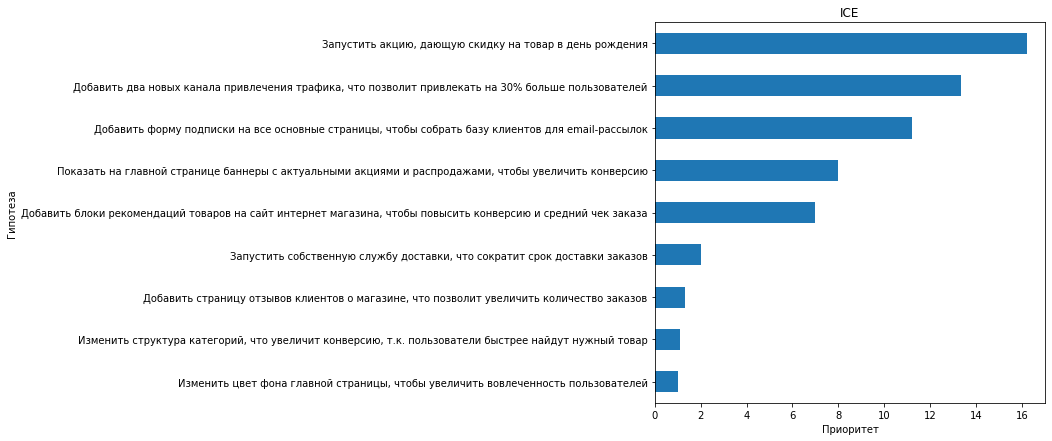

In [77]:
hypothesis.set_index('hypothesis')['ice'].sort_values().plot(kind='barh', figsize=(7, 7))
plt.title('ICE')
plt.xlabel('Приоритет')
plt.ylabel('Гипотеза')
plt.show()

Наибольший коэффициент имеет акция, которая дает скидку на товар в день рождения: ее влияние и уверенность имеют 9 из 10, при этом затраты на реализацию относительно небольшие.  
Вторая по приоритету гипотеза здесь - добавление двух новых каналов для привлечения пользователей: по влиянию она имеет максимальный балл, так как затронет абсолютно всех пользователей этих каналов, при этом сложность проверки гипотезы немного больше первой, а уверенность в правильности оценки параметров ниже.  
Также довольно высокий коэффициент имеет гипотеза о добавлении формы подписки на все страницы - она, как и предыдущие, имеет средний показатель сложности проверки и довольно высокую степень уверенности, но влияние, оказываемое на пользователей, будет ниже.  
Самый низкий коэффициент имеет гипотеза об изменении цвета фона главной страницы - оценки по каждому параметру для нее были минимальны.

Теперь добавим для оценки параметр охвата и аналогичным образом посчитаем **RICE**:

In [9]:
hypothesis['rice'] = (hypothesis['reach'] 
                      * hypothesis['impact'] 
                      * hypothesis['confidence'] 
                      / hypothesis['efforts']).round(2)
hypothesis.sort_values(by='rice', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


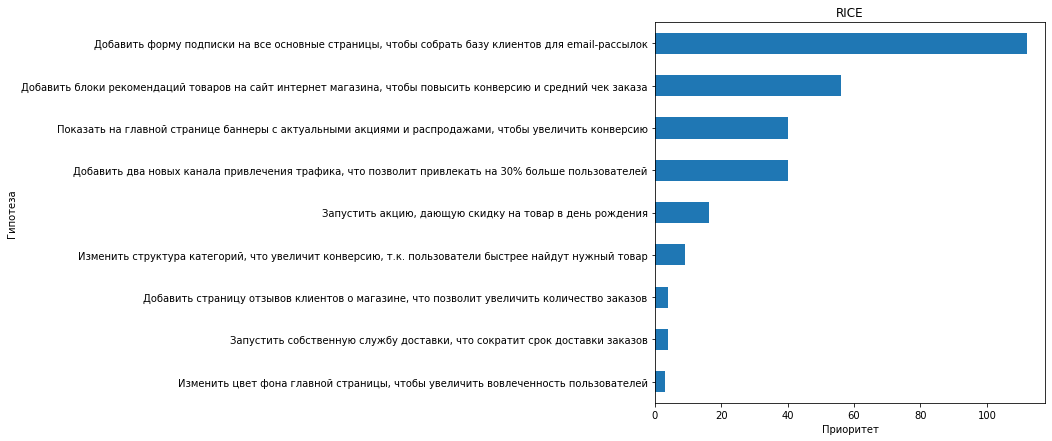

In [10]:
hypothesis.set_index('hypothesis')['rice'].sort_values().plot(kind='barh', figsize=(7, 7))
plt.title('RICE')
plt.xlabel('Приоритет')
plt.ylabel('Гипотеза')
plt.show()

Лидер предыдущего фреймворка сместился на пятую позицию. Действительно, акция в день рождения окажет очень сильное влияние, и о нем мы можем говорить с высокой степенью уверенности, однако охват пользователей будет минимальным - процент именинников среди всех, кто заходит на сайт, очень мал.  
На первом месте по этому фреймворку оказалась форма подписки на все основные страницы, которая на предыдущем графике замыкала тройку лидеров. Среди всех остальных гипотез она единственная, чей охват максимальный - 10 из 10.  
Следующей по величине коэффициента идет гипотеза о добавлении блока рекомендаций товаров на сайт, которая при анализе ICE занимала пятую позицию. Ее реализация также затронет очень многих пользователей - Reach оценен в 8/10.  
Изменение цвета фона главной страницы по-прежнему имеет наименьший приоритет. Охват пользователей для нее довольно низкий и этот параметр не внес значительных изменений. Также стоит отметить, что в первую пятерку входят одни те же гипотезы при приоритизации по обоим фреймворкам.

Таким образом мы приоритизировали гипотезы, используя фреймворки ICE и RICE и выяснили, что параметр охвата пользователей может оказать сильное влияние на изменение приоритета.  
По результатам анализа с применением ICE наивысший коэффициент получила акция, дающая скидку на товар в день рождения. RICE показал, что в первую очередь для тестирования следует выбрать добавление формы подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.

## 2. Анализ A/B-теста <a id='test'></a>
[Назад к оглавлению](#content)

На данном этапе мы рассмотрим результаты проверки гипотезы при помощи A/B-тестирования, выявим есть ли различия между группами по показателям конверсии и среднего чека и определим, насколько полученные результаты статистически значимы для нас.  

Рассмотрим таблицу с заказами и проведем предобработку данных:

In [11]:
orders = pd.read_csv('/datasets/orders.csv')
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [12]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


Здесь нам нужно дать более удобные названия столбцам и привести к правильному формату столбец с датой:

In [13]:
orders.rename(columns={'transactionId':'transaction_id', 'visitorId':'visitor_id'}, inplace=True)

In [14]:
orders['date'] = pd.to_datetime(orders['date'])

In [15]:
# проверяем
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transaction_id    1197 non-null int64
visitor_id        1197 non-null int64
date              1197 non-null datetime64[ns]
revenue           1197 non-null int64
group             1197 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


Таким же образом просмотрим таблицу с посетителями:

In [16]:
visitors = pd.read_csv('/datasets/visitors.csv')
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [17]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Столбец с датой вновь имеет строковый тип:

In [18]:
visitors['date'] = pd.to_datetime(visitors['date'])

Также убедимся, что данные не имеют дублирующихся строк:

In [19]:
orders.duplicated().sum()

0

In [20]:
visitors.duplicated().sum()

0

Теперь данные готовы к анализу.

### 2.1. Графики кумулятивной выручки, среднего чека и конверсии по группам <a id='cum_plots'></a>
[Назад к оглавлению](#content)

На первом шаге анализа эксперимента мы узнаем как изменялась кумулятивная (накапливаемая) выручка в зависимости от группы, средний чек и конверсия. Здесь нам нужно подсчитать динамику доходов, заказов и пользователей по группам на протяжении всего теста, причем данные за каждый день будет включать в себя сумму данных за все предыдущие дни, чтобы стабилизировать результаты.  

Для начала нам нужно создать массив данных, где каждой строчке будет соответствовать уникальная дата и группа испытуемых:

In [21]:
dates_groups = orders[['date', 'group']].drop_duplicates().sort_values(by=['date', 'group'])
dates_groups.head()

,date,group
55,2019-08-01,A
66,2019-08-01,B
175,2019-08-02,A
173,2019-08-02,B
291,2019-08-03,A


Добавим к этому массиву количество покупателей в каждой группе за день, количество их заказов и сумму выручки. Все данные будут с накоплением.  
Для этого применим лямбда-функцию: до тех пор, пока значение даты для каждой группы в таблице `orders` не будут равны дате в таблице `orders_aggregated`, в ней будет суммироваться количество пользователей, заказов и выручка:

In [22]:
orders_aggregated = (dates_groups
                     .apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], 
                                                            orders['group'] == x['group'])]
                            .agg({'date':'max',
                                 'group':'max',
                                 'transaction_id':'nunique',
                                 'visitor_id':'nunique',
                                 'revenue':'sum'}), axis=1)
                    .rename(columns={'transaction_id':'orders', 
                                     'visitor_id':'buyers'}))
orders_aggregated.head()

,date,group,orders,buyers,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874


Таким же способом добавим количество посетителей в группе на каждую дату:

In [23]:
visitors_aggregated = (dates_groups
                     .apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], 
                                                            visitors['group'] == x['group'])]
                            .agg({'date':'max',
                                 'group':'max',
                                 'visitors':'sum'}), axis=1))
visitors_aggregated.head()

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


Объединим две полученные таблицы по дате:

In [24]:
cum_data = orders_aggregated.merge(visitors_aggregated, on=['date', 'group'])
cum_data.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


Для подсчета **кумулятивной выручки** разделим полученные таблицу на группы и построим график:

In [25]:
cum_revenueA = cum_data[cum_data['group'] == 'A'][['date', 'revenue', 'orders']]
cum_revenueB = cum_data[cum_data['group'] == 'B'][['date', 'revenue', 'orders']]

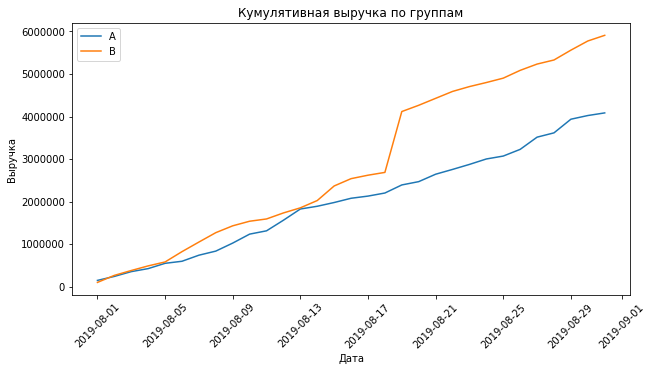

In [26]:
plt.plot(cum_revenueA['date'], cum_revenueA['revenue'], label='A')
plt.plot(cum_revenueB['date'], cum_revenueB['revenue'], label='B')
plt.legend()
plt.xticks(rotation=45)
plt.title('Кумулятивная выручка по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.show()

Выручка обеих групп практически линейно увеличивается на протяжении всего теста. Первые 5 дней она была идентичной, после чего группа В вырвалась по этому показателю вперед. Во второй половине месяца произошел резкий скачок во второй группе: вероятнее всего это было связано с большим количеством заказов в этот день, либо совершением одного или нескольких очень дорогоих заказов. Такой рост может свидетельствовать о наличии выбросов в данных.

Построим график **кумулятивного среднего чека** по группам. Его значение будет равно отношению выручки к количеству совершенных заказов:

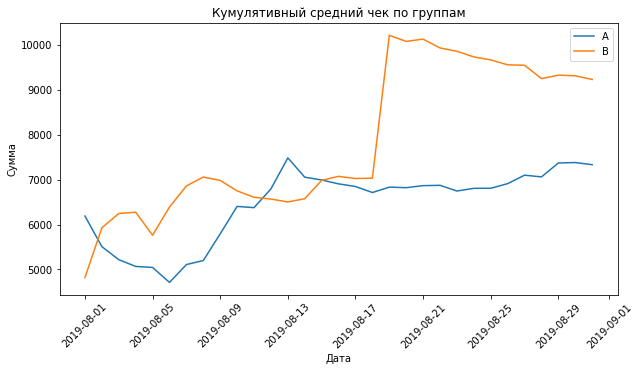

In [27]:
plt.plot(cum_revenueA['date'], 
         cum_revenueA['revenue'] / cum_revenueA['orders'], 
         label='A')
plt.plot(cum_revenueB['date'], 
         cum_revenueB['revenue'] / cum_revenueB['orders'], 
         label='B')
plt.legend()
plt.xticks(rotation=45)
plt.title('Кумулятивный средний чек по группам')
plt.xlabel('Дата')
plt.ylabel('Сумма')
plt.show()

Средний чек начинает стабилизироваться почти в самом конце теста. Здесь мы также видим сильный скачок вверх в группе В, а значит можем предположить, что он связан именно с аномальным ростом выручки - какой-то из заказов имел очень высокую стоимость. Из-за этого сложно сделать вывод о том, есть ли ощутимая разница среднего чека между группами.  

Построим график **относительного изменения кумулятивного среднего чека** группы B к группе A.  
для этого нам нужно объединить две группы по дате и произвести расчет формуле `кумулятивная метрика группы B / кумулятивная метрика группы A - 1`

In [28]:
merged_cum_revenue = (pd.merge(cum_revenueA,
              cum_revenueB,
              on='date',
              how='outer',
              suffixes=['A','B']))
merged_cum_revenue.head()

,date,revenueA,ordersA,revenueB,ordersB
0,2019-08-01,148579,24,101217,21
1,2019-08-02,242401,44,266748,45
2,2019-08-03,354874,68,380996,61
3,2019-08-04,425699,84,489567,78
4,2019-08-05,549917,109,581995,101


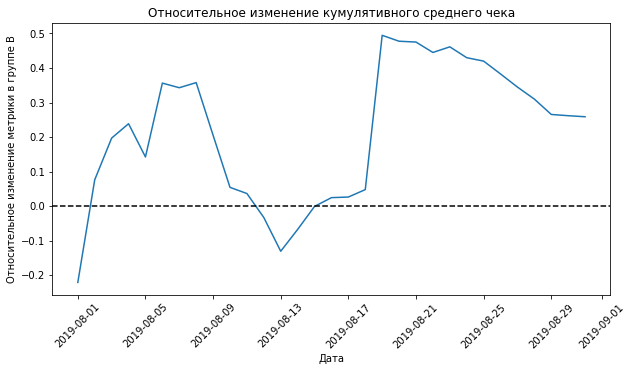

In [29]:
plt.plot(merged_cum_revenue['date'],
        (merged_cum_revenue['revenueB'] / merged_cum_revenue['ordersB'])
        / (merged_cum_revenue['revenueA'] / merged_cum_revenue['ordersA']) - 1)
plt.axhline(y=0, color='black', linestyle='--') # добавим горизонтальную пунктирную линию на нулевой отметке
plt.xticks(rotation=45)
plt.title('Относительное изменение кумулятивного среднего чека')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение метрики в группе В')
plt.show()

Величина среднего чека в группе В быстро вышла вперед, но спустя неделю начала активно уменьшаться. Минимальный показатель с начала эксперимента был зафиксрован 13 августа, после чего разница вновь стала возрастать в пользу второй группы. Скачок выручки 19-го числа сделал разницу между группами максимальным. Очевидно, что такой выброс повлиял на все показатели, связанные с выручкой продукта.

Теперь изучим конверсию.  
Построим график **кумулятивной конверсии** по группам. Для ее находжения разделим столбец количества заказов таблицы `cum_data` на количество посетителей:

In [30]:
cum_data['conversion'] = cum_data['orders'] / cum_data['visitors']
cum_data.head()

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,24,20,148579,719,0.033380
1,2019-08-01,B,21,20,101217,713,0.029453
2,2019-08-02,A,44,38,242401,1338,0.032885
3,2019-08-02,B,45,43,266748,1294,0.034776
4,2019-08-03,A,68,62,354874,1845,0.036856


Аналогично с расчетом кумулятивной выручки разобьем данные на группы и построим по ним график:

In [31]:
cum_dataA = cum_data[cum_data['group'] == 'A']
cum_dataB = cum_data[cum_data['group'] == 'B']

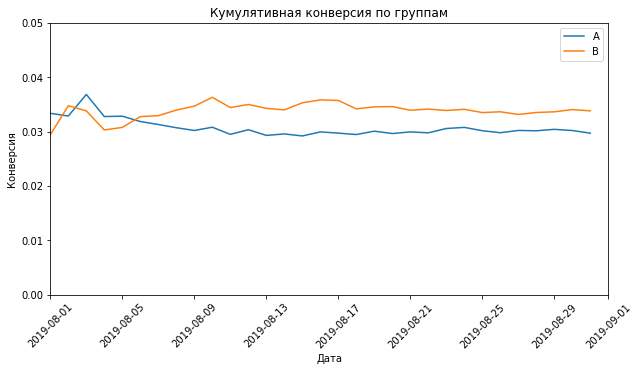

In [32]:
plt.plot(cum_dataA['date'], cum_dataA['conversion'], label='A')
plt.plot(cum_dataB['date'], cum_dataB['conversion'], label='B')
plt.axis(['2019-08-01', '2019-09-01', 0, 0.05]) # задаем границы осей
plt.legend()
plt.xticks(rotation=45)
plt.title('Кумулятивная конверсия по группам')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.show()

Показатель конверсии стабилизировался во второй половине месяца. Большую часть времени группа В демонстрирует лучшие результаты - конверсия выше приблизительно на 0.5 процентных пунктов.

Рассмотрим также график **относительного изменения кумулятивной конверсии** группы B к группе A. Здесь снова по аналогии с расчетом относительнго изменения среднего чека объединим группы по дате и найдем отношение конверсии группы В к А и вычтем из нее единицу:

In [33]:
merged_cum_conversion = (pd.merge(cum_dataA[['date', 'conversion']], 
                                  cum_dataB[['date', 'conversion']], 
                                  on='date', 
                                  suffixes=['A', 'B']))
merged_cum_conversion.head()

,date,conversionA,conversionB
0,2019-08-01,0.033380,0.029453
1,2019-08-02,0.032885,0.034776
2,2019-08-03,0.036856,0.033833
3,2019-08-04,0.032787,0.030315
4,2019-08-05,0.032851,0.030793


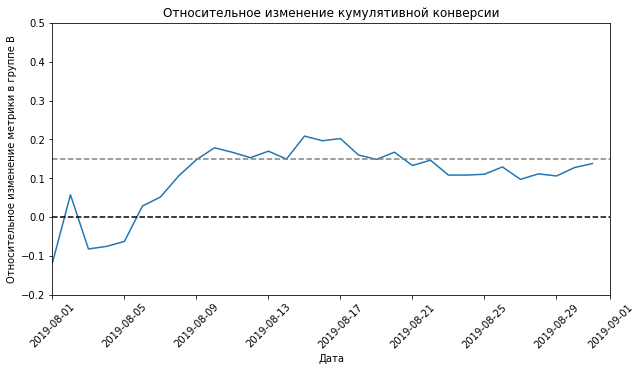

In [34]:
plt.plot(merged_cum_conversion['date'], 
        merged_cum_conversion['conversionB']
         / merged_cum_conversion['conversionA'] - 1)
plt.axis(['2019-08-01', '2019-09-01', -0.2, 0.5])
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.xticks(rotation=45)
plt.title('Относительное изменение кумулятивной конверсии')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение метрики в группе В')
plt.show()

На графике мы вновь можем наблюдать стабильное лидерство группы В - уже в конце первой недели ее конверсия превысила этот показатель в контрольной группе.  
Резюмируя анализ конверсии, можем сделать вывод, что данная метрика в группе В стабильно выше.

### 2.2. Точечный график количества и стоимостей заказов по пользователям. Анализ выбросов <a id='scatters'></a>
[Назад к оглавлению](#content)

Ранее мы обнаружили сильный скачок выручки, который повлиял на результаты нашего теста. Мы сделали предположение, что такой скачок явился следствием выбросов в данных. Теперь рассмотрим распределения заказов и их стоимостей и исследуем перцентели этих показателей, чтобы выяснить какие значения мы можем отнести к артефактам.  

Построим гистограмму **количества покупок**. Сгруппируем тублицу `orders` по пользователям и посчитаем сколько заказов совершил каждый из них:

In [35]:
orders_by_visitor = (orders
                     .groupby('visitor_id', as_index=False)
                     .agg({'transaction_id':'nunique'})
                     .rename(columns={'transaction_id':'orders'}))
orders_by_visitor.sort_values(by='orders', ascending=False).head()

,visitor_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5


Есть два пользователя, которые совершили по 11 заказов, также несколько имеют заказы больше 5-и.

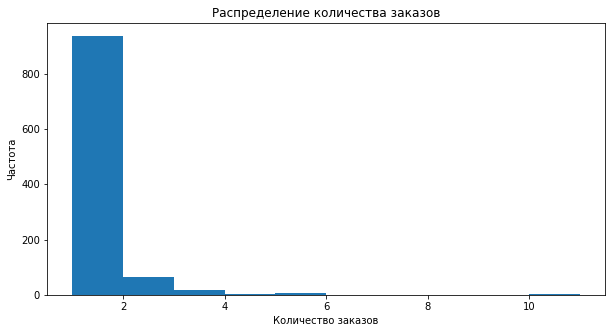

In [36]:
plt.hist(orders_by_visitor['orders'])
plt.title('Распределение количества заказов')
plt.xlabel('Количество заказов')
plt.ylabel('Частота')
plt.show()

Абсолютное большинство пользователей совершили только один заказ. Менее 100 из них делали заказы дважды, и только несколько десятков оплатили 3 и более покупки.  
Теперь посмотрим на диаграмму рассеяния количества заказов:

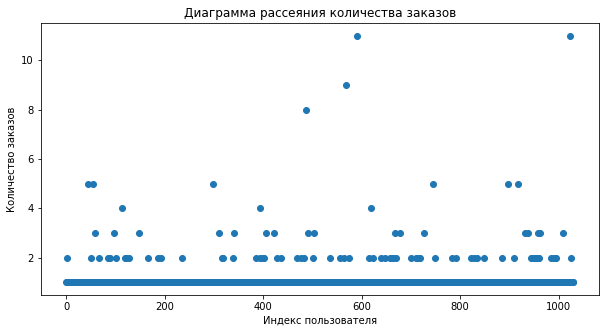

In [37]:
# значения оси х лежат в диапазоне от 0 до длины таблицы orders_by_visitor
x_values_orders = pd.Series(range(0, len(orders_by_visitor))) 
plt.scatter(x_values_orders, orders_by_visitor['orders'])
plt.title('Диаграмма рассеяния количества заказов')
plt.xlabel('Индекс пользователя')
plt.ylabel('Количество заказов')
plt.show()

По графику видно несколько единичных пользователей, которые совершили более трех заказов.  
Можем отметить это количество как границу выбросов, однако посмотрим на долю таких пользователей. Посчитаем 95-й и 99-й перцентили количества заказов на пользователя и выберем границу для определения аномальных юзеров:

In [38]:
np.percentile(orders_by_visitor['orders'], [95, 99])

array([2., 4.])

Не более 95% всех пользователей сделал более 2-х заказов. Доля же тех, кто совершил 4 и больше заказов составляет только 1%.  
Мы будем считать аномальными тех пользователей, которые совершили **более 3-х заказов**.

Теперь посмотрим на распределение **стоимостей заказов**. Построим гистограмму на основе столбца с доходами таблицы `orders`:

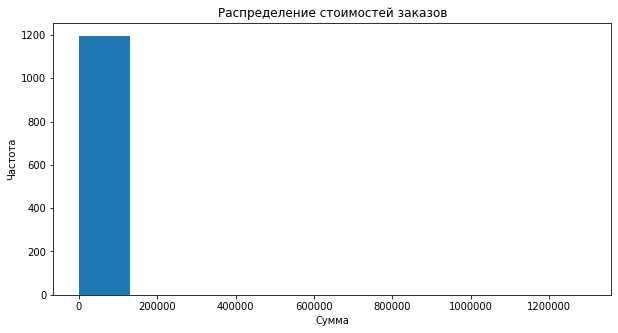

In [39]:
plt.hist(orders['revenue'])
plt.title('Распределение стоимостей заказов')
plt.xlabel('Сумма')
plt.ylabel('Частота')
plt.show()

Исходя из диаграммы, абсолютное большинство покупателей потратили на заказы не более 50000. Примерно в районе этой суммы может находиться границы выбросов для стоимости заказов.  
Аналогичным образом построим для данного показателя диаграмму рассеяния:

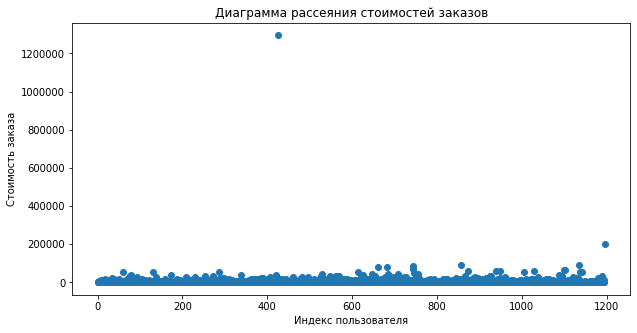

In [40]:
x_values_revenue = pd.Series(range(0, len(orders)))
plt.scatter(x_values_revenue, orders['revenue'])
plt.title('Диаграмма рассеяния стоимостей заказов')
plt.xlabel('Индекс пользователя')
plt.ylabel('Стоимость заказа')
plt.show()

Здесь мы имеем один очевидный выброс - сумма заказа превысила 1,2 млн. Это и есть то самое значение, которое повлияло на результат проведения А/В-теста и сделало большой разрыв между двумя группами. Также выделяется покупка в районе 200 тыс. Большинство же заказов, как и на гистограмме, находятся в пределах 50 тыс.  
Чтобы окончательно определиться с границей выбросов посмотрим на перцентили:

In [41]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Не более 5% покупателей совершали заказ на сумму более 28000. Около 60000 потратили на покупки менее 1%. 
Остановимся на отметке в **50000** для определения аномальной суммы заказа.

### 2.3. Расчет статистической значимости различий в конверсии и среднем чеке между группами <a id='p-value'></a>
[Назад к оглавлению](#content)

На заключительном шаге анализа результатов А/В-теста мы определим, являются ли различия между группами статистически значимыми. Нами будет проверено две гипотезы:
1. О равенстве конверсии между группами.
2. О равенстве среднего чека между группами. 

Проверять p-value для конверсии и среднего чека мы будем по двум массивам данным: "сырым" - которые были у нас изначально и в которых мы обнаружили выбросы и "очищенным" - после избавления от артефактных значений в них. Далее сравним как сильно выбросы в данных могут повлиять на данный показатель.  

Зададим уровень статистической значимости 5%.
### alpha = 0.05

Для определения статистической значимости различий мы будем применять **непараметрический тест Уилкоксона-Манна-Уитни**. Он покажет большую точность для данных, в которых имеются артефактные значения.  
Первая нулевая гипотеза будет сформулирована соледующим образом:  
**$H_{0}$ - конверсия между двумя исследуемыми группами не имеет различий**.  
Альтернативная гипотеза при этом: **$H_{1}$ - конверсия между двумя исследуемыми группами имеет статистически значимое различие.**

Создадим срезы данных таблицы `visitors`, где посчитаем сколько пользователей было в обеих группах на каждую дату. Их сумма нам понадобится для проведения U-теста:

In [42]:
visitorsA_daily = visitors[visitors['group']=='A'].drop('group', axis=1)
visitorsA_daily['visitors_cum'] = visitorsA_daily['visitors'].cumsum()
visitorsA_daily.head()

,date,visitors,visitors_cum
0,2019-08-01,719,719
1,2019-08-02,619,1338
2,2019-08-03,507,1845
3,2019-08-04,717,2562
4,2019-08-05,756,3318


In [43]:
visitorsB_daily = visitors[visitors['group']=='B'].drop('group', axis=1)
visitorsB_daily['visitors_cum'] = visitorsB_daily['visitors'].cumsum()
visitorsB_daily.head()

,date,visitors,visitors_cum
31,2019-08-01,713,713
32,2019-08-02,581,1294
33,2019-08-03,509,1803
34,2019-08-04,770,2573
35,2019-08-05,707,3280


Теперь посчитаем, сколько заказов совершил каждый пользователь в обеих группах:

In [44]:
orders_by_visitorsA = (orders[orders['group']=='A']
                    .groupby('visitor_id', as_index=False)
                    .agg({'transaction_id':'nunique'})
                    .rename(columns={'transaction_id':'orders'}))
orders_by_visitorsA.head()

,visitor_id,orders
0,8300375,1
1,11685486,1
2,54447517,1
3,66685450,1
4,78758296,1


In [45]:
orders_by_visitorsB = (orders[orders['group']=='B']
                    .groupby('visitor_id', as_index=False)
                    .agg({'transaction_id':'nunique'})
                    .rename(columns={'transaction_id':'orders'}))
orders_by_visitorsB.head()

,visitor_id,orders
0,5114589,1
1,6958315,1
2,8300375,1
3,39475350,1
4,47206413,1


Создадим два массива данных по группам для проведения U-теста. Каждый массив будет представлять собой тех пользователей, которые совершили заказ плюс пользователи, которые заказов не совершали. Их количество мы определим, если из суммы посетителей вычтем длину таблицы `orders_by_visitors`. После этого передадим полученную цифру в Series, где ей будет соответствовать число индексов, заполненное нулями. Для построения выборок соединим полученный Series со столбцом заказов таблицы `orders_by_visitors`:

In [46]:
sampleA_orders = (pd.concat([orders_by_visitorsA['orders'],
                    pd.Series(0, 
                              index=np.arange(visitorsA_daily['visitors'].sum() 
                                              - len(orders_by_visitorsA)),
                              name='orders')], axis=0))
sampleA_orders

0        1
1        1
2        1
3        1
4        1
        ..
18228    0
18229    0
18230    0
18231    0
18232    0
Name: orders, Length: 18736, dtype: int64

In [47]:
sampleB_orders = (pd.concat([orders_by_visitorsB['orders'],
                    pd.Series(0, 
                              index=np.arange(visitorsB_daily['visitors'].sum() 
                                              - len(orders_by_visitorsB)),
                              name='orders')], axis=0))
sampleB_orders

0        1
1        1
2        1
3        1
4        1
        ..
18325    0
18326    0
18327    0
18328    0
18329    0
Name: orders, Length: 18916, dtype: int64

Наконец, передаем полученные выборки в качестве параметров теста Манна-Уитни:

In [48]:
stats.mannwhitneyu(sampleA_orders, sampleB_orders)

MannwhitneyuResult(statistic=176473106.0, pvalue=0.008396177528376304)

**p-value = 0,0083**  
По результатам теста **конверсия в группах А и В имеет статистически значимое различие**, а значит мы отвергаем нулевую гипотезу об их равенстве.

Также посмотрим, чему равен **относительный прирост конверсии** группы В:

In [49]:
sampleB_orders.mean() / sampleA_orders.mean() - 1

0.13807884655320146

Конверсия контрольной группы оказалсь практически на 14% меньше, можем зафиксировать преимущество группы В по данному показателю.

Теперь определим, являются ли статистически значимыми различия в среднем чеке между двумя группами.  Гипотезы здесь будут сформулированы так:  
**$H_{0}$ - средний чек между двумя исследуемыми группами не имеет различий.**  
**$H_{1}$ - средний чек между двумя исследуемыми группами имеет статистически значимое различие.**  
Для этого в качестве параметров передадим данные о выручке с заказов:

In [50]:
sampleA_revenue = orders[orders['group']=='A']['revenue']
sampleB_revenue = orders[orders['group']=='B']['revenue']

In [51]:
stats.mannwhitneyu(sampleA_revenue, sampleB_revenue)

MannwhitneyuResult(statistic=176175.0, pvalue=0.3646454927716229)

**p-value=0.3646**  
Полученный результат оказался больше заданного alpha, следовательно мы не можем отвергнуть нулевую гипотезу о равенстве среднего чека между двумя группами.  
Снова посмотрим на прирост данного показателя в группе В:

In [52]:
sampleB_revenue.mean() / sampleA_revenue.mean() - 1

0.2587136699126005

Несмотря на отсутствие статистической значимости, средний чек во второй группе на 25% выше контрольной.

Далее мы посчтаем статистическую значимость различий в **конверсии между группами по "очищенным" данным**. Для этого выделим тех пользователей, которые совершили более 3-х заказов и потратили более 50000 и построим массивы данных для двух групп без учета таких пользователей:

In [53]:
abnormal_orders = orders_by_visitorsA[orders_by_visitorsA['orders'] > 3]
abnormal_orders.shape[0] # показывает количество выбранных пользователей

6

In [54]:
abnormal_revenue = orders[orders['revenue'] > 50000]
abnormal_revenue.shape[0]

21

In [55]:
abnormal_visitors = (pd.concat([abnormal_orders['visitor_id'], 
                                abnormal_revenue['visitor_id']], 
                               axis=0)
                     .drop_duplicates()) # удаляем тех, кто попал к аномалиям и по заказам и по сумме
abnormal_visitors.shape[0]

23

Из всех данных мы исключаем 23 пользователей.

In [56]:
sampleA_orders_filt = (pd.concat([orders_by_visitorsA
                           [~ orders_by_visitorsA['visitor_id']
                                           .isin(abnormal_visitors)]['orders'],
                         pd.Series(0,
                                  index=np.arange(visitorsA_daily['visitors'].sum() 
                                                  - len(orders_by_visitorsA)),
                                  name='orders')], axis=0))
sampleA_orders_filt

0        1
1        1
2        1
3        1
4        1
        ..
18228    0
18229    0
18230    0
18231    0
18232    0
Name: orders, Length: 18719, dtype: int64

In [57]:
sampleB_orders_filt = (pd.concat([orders_by_visitorsB
                           [~ orders_by_visitorsB['visitor_id']
                                           .isin(abnormal_visitors)]['orders'],
                         pd.Series(0,
                                  index=np.arange(visitorsB_daily['visitors'].sum() 
                                                  - len(orders_by_visitorsB)),
                                  name='orders')], axis=0))
sampleB_orders_filt

0        1
1        1
2        1
3        1
4        1
        ..
18325    0
18326    0
18327    0
18328    0
18329    0
Name: orders, Length: 18902, dtype: int64

In [58]:
stats.mannwhitneyu(sampleA_orders_filt, sampleB_orders_filt)

MannwhitneyuResult(statistic=176152123.0, pvalue=0.005806158332897509)

**p-value=0.0058**  
Таким образом вероятность случайного получения таких или еще более экстремальных различий между группами уменьшилась. Обе группы имеют статистически значимое различие в конверсии и по "сырым", и по "очищенным" данным.

In [59]:
sampleB_orders_filt.mean() / sampleA_orders_filt.mean() - 1

0.17456378431715125

Относительный прирост конверсии группы В увеличился почти на 4% после удаления артефактных значений.

Аналогичным образом посмотрим как изменились результаты U-теста для **среднего чека после избавления данных от выбросов**:

In [60]:
sampleA_revenue_filt = (orders[(orders['group']=='A') 
                               & (~ orders['visitor_id']
                                  .isin(abnormal_visitors))]['revenue'])
sampleA_revenue_filt

2       400  
7       1044 
8       13710
10      4008 
12      7370 
        ...  
1187    750  
1188    112  
1193    3190 
1194    10550
1195    100  
Name: revenue, Length: 516, dtype: int64

In [61]:
sampleB_revenue_filt = (orders[(orders['group']=='B') 
                                & (~ orders['visitor_id'].isin(abnormal_visitors))]['revenue'])
sampleB_revenue_filt

0       1650 
1       730  
3       9759 
4       2308 
5       2210 
        ...  
1186    15380
1189    31550
1190    8600 
1191    16490
1192    6490 
Name: revenue, Length: 612, dtype: int64

In [62]:
stats.mannwhitneyu(sampleA_revenue_filt, sampleB_revenue_filt)

MannwhitneyuResult(statistic=156589.0, pvalue=0.405284021064114)

**p-value=0.4052**  
После "очистки" исходных данных вероятность получить различия случайно увеличилась до 40%. Фиксируем отсутствие статистической значимости в различиях между размером среднего чека для групп А и В.

In [63]:
sampleB_revenue_filt.mean() / sampleA_revenue_filt.mean() - 1

0.023808605958757667

Без артефактов прирост данного показателя для группы В уменьшился с 25% до 23%.

### 2.4. Сравнение графиков по "сырым" и "очищенным" данным <a id='compare'></a>
[Назад к оглавлению](#content)


Последнее, что мы можем сделать перед принятием решения о дальнейшем проведении А/В-теста - сравнить графики кумулятивной выручки, среднего чека и конверсии по группам, которые проводили в [пункте 2.1](#cum_plots) после очистки данных от выбросов:

In [78]:
orders_filt = orders[~ orders['visitor_id'].isin(abnormal_visitors)]
ordersA_filt = (orders_filt[orders_filt['group'] == 'A']
                .groupby('date', as_index=False)
                .agg({'revenue':'sum'})
                .sort_values(by='date')) 
# добавляем столбец с кумулятивной выручкой
ordersA_filt['cum_revenue'] = ordersA_filt['revenue'].cumsum() 
ordersA_filt.head()

,date,revenue,cum_revenue
0,2019-08-01,142779,142779
1,2019-08-02,93822,236601
2,2019-08-03,112473,349074
3,2019-08-04,66415,415489
4,2019-08-05,124218,539707


In [65]:
ordersB_filt = (orders_filt[orders_filt['group'] == 'B']
                .groupby('date', as_index=False)
                .agg({'revenue':'sum'})
                .sort_values(by='date')) 
ordersB_filt['cum_revenue'] = ordersB_filt['revenue'].cumsum()
ordersB_filt.head()

,date,revenue,cum_revenue
0,2019-08-01,101217,101217
1,2019-08-02,162043,263260
2,2019-08-03,114248,377508
3,2019-08-04,105771,483279
4,2019-08-05,90008,573287


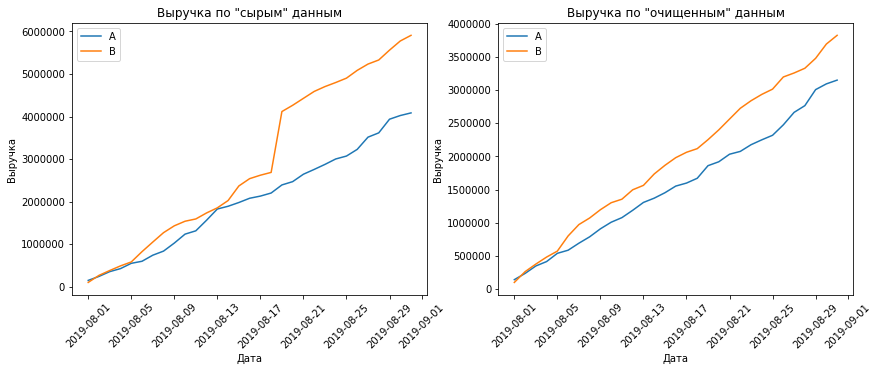

In [66]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(cum_revenueA['date'], cum_revenueA['revenue'], label='A')
plt.plot(cum_revenueB['date'], cum_revenueB['revenue'], label='B')
plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.title('Выручка по "сырым" данным')

plt.subplot(1,2,2)
plt.plot(ordersA_filt['date'], ordersA_filt['cum_revenue'], label='A')
plt.plot(ordersB_filt['date'], ordersB_filt['cum_revenue'], label='B')
plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.title('Выручка по "очищенным" данным')

plt.show()

После избавления от выбросов график кумулятивной выручки стал более линейным, и лидерство группы В зафиксировалось, начиная с 5-го дня эксперимента.

Рассмотрим изменения среднего чека:

In [67]:
# считаем количество заказов и сумму выручки по группам на каждый день
orders_groups_filt = (orders_filt
                .groupby(['date', 'group'], 
                         as_index=False)
                .agg({'transaction_id':'nunique', 
                      'revenue':'sum'})
                .rename(columns={'transaction_id':'orders'}))
orders_groups_filt.head()

,date,group,orders,revenue
0,2019-08-01,A,23,142779
1,2019-08-01,B,21,101217
2,2019-08-02,A,20,93822
3,2019-08-02,B,23,162043
4,2019-08-03,A,24,112473


In [68]:
# выделяем группу А и добавляем столбцы с кумулятивными заказами и выручкой
ordersA_filt = orders_groups_filt[orders_groups_filt['group'] == 'A']
ordersA_filt['orders_cum'] = ordersA_filt['orders'].cumsum()
ordersA_filt['revenue_cum'] = ordersA_filt['revenue'].cumsum()
ordersA_filt.head()

,date,group,orders,revenue,orders_cum,revenue_cum
0,2019-08-01,A,23,142779,23,142779
2,2019-08-02,A,20,93822,43,236601
4,2019-08-03,A,24,112473,67,349074
6,2019-08-04,A,13,66415,80,415489
8,2019-08-05,A,25,124218,105,539707


In [69]:
# выделяем группу В и добавляем столбцы с кумулятивными заказами и выручкой
ordersB_filt = orders_groups_filt[orders_groups_filt['group'] == 'B']
ordersB_filt['orders_cum'] = ordersB_filt['orders'].cumsum()
ordersB_filt['revenue_cum'] = ordersB_filt['revenue'].cumsum()
ordersB_filt.head()

,date,group,orders,revenue,orders_cum,revenue_cum
1,2019-08-01,B,21,101217,21,101217
3,2019-08-02,B,23,162043,44,263260
5,2019-08-03,B,16,114248,60,377508
7,2019-08-04,B,16,105771,76,483279
9,2019-08-05,B,22,90008,98,573287


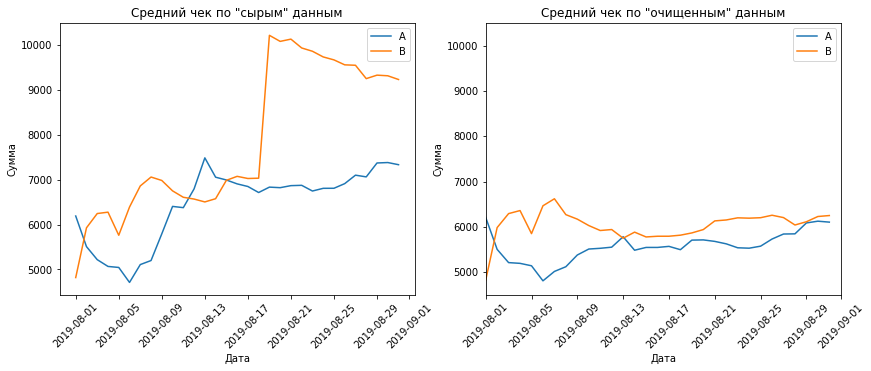

In [70]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(cum_revenueA['date'], 
         cum_revenueA['revenue'] / cum_revenueA['orders'], 
         label='A')
plt.plot(cum_revenueB['date'], 
         cum_revenueB['revenue'] / cum_revenueB['orders'], 
         label='B')
plt.legend()
plt.xticks(rotation=45)
plt.title('Средний чек по "сырым" данным')
plt.xlabel('Дата')
plt.ylabel('Сумма')

plt.subplot(1,2,2)
plt.plot(ordersA_filt['date'], 
         ordersA_filt['revenue_cum'] / ordersA_filt['orders_cum'],
         label='A')
plt.plot(ordersB_filt['date'], 
         ordersB_filt['revenue_cum'] / ordersB_filt['orders_cum'],
         label='B')
plt.axis(['2019-08-01', '2019-09-01', 4500, 10500])
plt.legend()
plt.xticks(rotation=45)
plt.title('Средний чек по "очищенным" данным')
plt.xlabel('Дата')
plt.ylabel('Сумма')

plt.show()

После очистки графики получились более симметричны и показатели стали меньше. На этот раз сумма среднего чека контрольной группы практически не превышает этот показатель в группе В в середине месяца. Сумма второй группы испытуемых больше практически на всем отрезке.

Наконец, изучим изменение конверсии:

In [71]:
# присоединяем таблицу visitors по дате и группе
orders_groups_filt = orders_groups_filt.merge(visitors, on=['date', 'group'])
orders_groups_filt.head()

,date,group,orders,revenue,visitors
0,2019-08-01,A,23,142779,719
1,2019-08-01,B,21,101217,713
2,2019-08-02,A,20,93822,619
3,2019-08-02,B,23,162043,581
4,2019-08-03,A,24,112473,507


In [72]:
# считаем конверсию
orders_groups_filt['conversion'] = orders_groups_filt['orders'] / orders_groups_filt['visitors']
orders_groups_filt.head()

,date,group,orders,revenue,visitors,conversion
0,2019-08-01,A,23,142779,719,0.031989
1,2019-08-01,B,21,101217,713,0.029453
2,2019-08-02,A,20,93822,619,0.032310
3,2019-08-02,B,23,162043,581,0.039587
4,2019-08-03,A,24,112473,507,0.047337


In [73]:
conversionA_filt = ordersA_filt.merge(visitors, on=['date', 'group'], how='left')
conversionA_filt['visitors_cum'] = conversionA_filt['visitors'].cumsum()
conversionA_filt['conversion'] = conversionA_filt['orders_cum'] / conversionA_filt['visitors_cum']
conversionA_filt.head()

,date,group,orders,revenue,orders_cum,revenue_cum,visitors,visitors_cum,conversion
0,2019-08-01,A,23,142779,23,142779,719,719,0.031989
1,2019-08-02,A,20,93822,43,236601,619,1338,0.032138
2,2019-08-03,A,24,112473,67,349074,507,1845,0.036314
3,2019-08-04,A,13,66415,80,415489,717,2562,0.031226
4,2019-08-05,A,25,124218,105,539707,756,3318,0.031646


In [74]:
conversionB_filt = ordersB_filt.merge(visitors, on=['date', 'group'], how='left')
conversionB_filt['visitors_cum'] = conversionB_filt['visitors'].cumsum()
conversionB_filt['conversion'] = conversionB_filt['orders_cum'] / conversionB_filt['visitors_cum']
conversionB_filt.head()

,date,group,orders,revenue,orders_cum,revenue_cum,visitors,visitors_cum,conversion
0,2019-08-01,B,21,101217,21,101217,713,713,0.029453
1,2019-08-02,B,23,162043,44,263260,581,1294,0.034003
2,2019-08-03,B,16,114248,60,377508,509,1803,0.033278
3,2019-08-04,B,16,105771,76,483279,770,2573,0.029538
4,2019-08-05,B,22,90008,98,573287,707,3280,0.029878


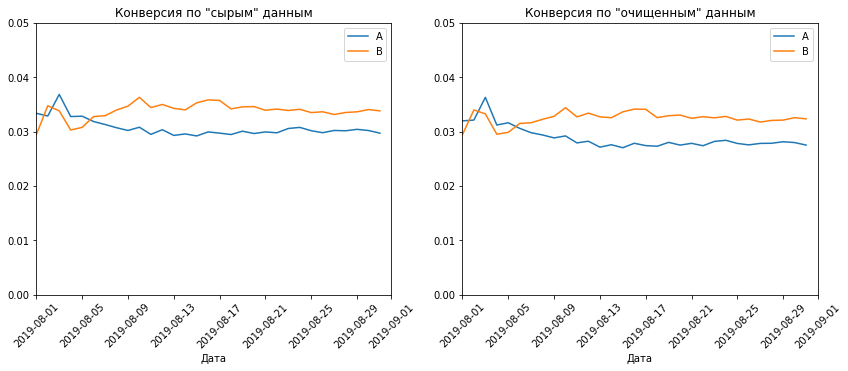

In [75]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(cum_dataA['date'], cum_dataA['conversion'], label='A')
plt.plot(cum_dataB['date'], cum_dataB['conversion'], label='B')
plt.axis(['2019-08-01', '2019-09-01', 0, 0.05])
plt.legend()
plt.xticks(rotation=45)
plt.title('Конверсия по "сырым" данным')
plt.xlabel('Дата')

plt.subplot(1,2,2)
plt.plot(cum_dataA['date'], conversionA_filt['conversion'], label='A')
plt.plot(cum_dataB['date'], conversionB_filt['conversion'], label='B')
plt.axis(['2019-08-01', '2019-09-01', 0, 0.05])
plt.legend()
plt.xticks(rotation=45)
plt.title('Конверсия по "очищенным" данным')
plt.xlabel('Дата')

plt.show()

Графики конверсии идентичны, выбросы на нее не повлияли.

## Вывод <a id='conclusion'></a>
[Назад к оглавлению](#content)

Таким образом мы провели приоритизацию сформулированных нами гипотез и оценили результаты А/В-тестирования одной из них.  
В нашем распоряжении было 8 сформулированных гипотез, которые нам предстояло приоритизировать, используя 2 фреймворка - ICE и RICE. Для этого гипотезы были оценены по 10-бальой шкале по следуюзим параметрам: охват, влияние, уверенность и усилия. По результатам проверки фреймворком ICE наибольший коэффициент продемонстрировала акция, которая дает скидку на товар в день рождения: ее влияние и уверенность имеют 9 из 10, при этом затраты на реализацию относительно небольшие. также в тройку вошли добавление двух новых каналов для привлечения пользователей и добавление формы подписки на все страницы для сбора базы клиентов. Самый низкий коэффициент имеет гипотеза об изменении цвета фона главной страницы - оценки по каждому параметру для нее были минимальны.  
Проверка при помощи RICE показала результаты, отличные от первых - параметр охвата пользователей смог внести существенные изменения в приоритет наших гипотез. По результатам самой приоритетной оказалась форма подписки на все основные страницы. Гипотезы о добавлении блока рекомендаций товаров на сайт и о показах на главной странице баннеров с актуальными акциями и предложениями вошли в тройку лидеров. Изменение цвета фона главной страницы по-прежнему представляло наименьший приоритет.

При анализе проведенного А/В-теста сначала мы рассмотрели графики кумулятивной выручки, сренего чека и конверсии.  
Выручка обеих групп практически линейно увеличивается на протяжении всего теста. Первые 5 дней она была идентичной, после чего группа В вырвалась по этому показателю вперед. Во второй половине месяца произошел резкий скачок во второй группе: вероятнее всего это было связано с большим количеством заказов в этот день, либо совершением одного или нескольких очень дорогоих заказов.  
Средний чек начал стабилизироваться почти в самом конце теста. Здесь мы также увидели сильный скачок вверх в группе В, а значит связь могла быть именно с аномальным ростом выручки, из-за которого сложно сделать однозначный вывод о разнице между двумя группами. Величина среднего чека в группе В быстро вышла вперед, но спустя неделю начала активно уменьшаться. Скачок выручки 19-го числа сделал разницу между группами максимальным.  
Показатель конверсии стабилизировался во второй половине месяца. Большую часть времени группа В демонстрировала лучшие результаты - конверсия выше приблизительно на 0.5 процентных пунктов. На графике относительной конверсии мы вновь наблюдали стабильное лидерство группы В - уже в конце первой недели ее конверсия превысила этот показатель в контрольной группе.  
Для определения аномальных значений мы изучили точечные графики количества заказов и их стоимостей. По графику количества было видно несколько единичных пользователей, которые совершили более трех заказов. Разбивка данных на перцентили показала, что более 95% всех пользователей сделал более 2-х заказов,а доля тех, кто совершил 4 и больше заказов составила только 1%.  
График стоимости заказов показал один очевидный выброс, где сумма превысила 1,2 млн. Это и есть то самое значение, которое повлияло на результат проведения А/В-теста и сделало большой разрыв между двумя группами. Большинство же заказов находились в пределах 50 тыс, а разбивка на перцентили показала, что около 60000 потратили на покупки менее 1% пользователей.  

Заключительным этапом анализа была проверка статистической значимости различий двух групп. Для этого мы применяли непараметрический тест Уилкоксона-Манна-Уитни, который способен покахать большую точность для данных, в которых имеются артефактные значения.
Нулевая гипотеза была сформулирована следующим образом: конверсия и средний чек между двумя группами не различаются. Уровень статистической значимости был принят 5%.  
По результатам теста конверсия в группах А и В имеет статистически значимое различие, а значит мы отвергаем нулевую гипотезу об их равенстве. Конверсия контрольной группы оказалсь практически на 14% меньше и мы смогли зафиксировать преимущество группы В по данному показателю.  
Полученный результат p-значения при сравнении средних чеков оказался больше заданного alpha, следовательно мы не смогли отвергнуть нулевую гипотезу ою их равенстве, несмотря на то, что средний чек во второй группе на 25% выше .  
После очисти данных от выбросов результаты теста не принесли серьезных изменений.

**В результате проведения А/В-тестирования нами было достигунуто статистически значимое различие конверсий между двумя группами в пользу группы В, а также отсутствие статистической значимости в различиях среднего чека между ними. Таким образом нами принято решение остановить дальнейшее проведение теста и зафиксировать победу группы В, тем самым признав данное тестирование успешным.**